In [2]:
# Installer pyreadstat si besoin
!pip install pyreadstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 19.8 MB/s eta 0:00:00


# 📊 Préparation des Données:

In [40]:
import pyreadstat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from google.colab import files
uploaded = files.upload()


Saving scoring.sav to scoring.sav


In [41]:
# Charger le fichier .sav
df,meta = pyreadstat.read_sav("/content/scoring.sav")

# Aperçu des données
df.head()

,Age,Marital,Expenses,Income,Amount,Price,Statut1
0,30.0,2.0,73.0,129.0,800.0,846.0,0.0
1,58.0,3.0,48.0,131.0,1000.0,1658.0,0.0
2,46.0,2.0,90.0,200.0,2000.0,2985.0,1.0
3,24.0,1.0,63.0,182.0,900.0,1325.0,0.0
4,26.0,1.0,46.0,107.0,310.0,910.0,0.0


In [42]:
df.describe()

,Age,Marital,Expenses,Income,Amount,Price,Statut1
count,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000
mean,37.902463,1.898522,61.765517,150.505419,1034.745813,1439.184236,0.268966
std,10.967288,0.589644,20.779157,98.396812,452.833277,603.421422,0.443641
min,18.000000,1.000000,35.000000,0.000000,100.000000,270.000000,0.000000
25%,29.000000,2.000000,45.000000,96.500000,750.000000,1127.500000,0.000000
50%,36.000000,2.000000,60.000000,133.000000,1000.000000,1375.000000,0.000000
75%,46.000000,2.000000,75.000000,185.000000,1300.000000,1637.500000,1.000000
max,68.000000,5.000000,173.000000,959.000000,3800.000000,8800.000000,1.000000


#💠 Analyse des Données :





In [43]:
# Valeurs manquantes
print(df.isnull().sum())

Age         0
Marital     0
Expenses    0
Income      0
Amount      0
Price       0
Statut1     0
dtype: int64


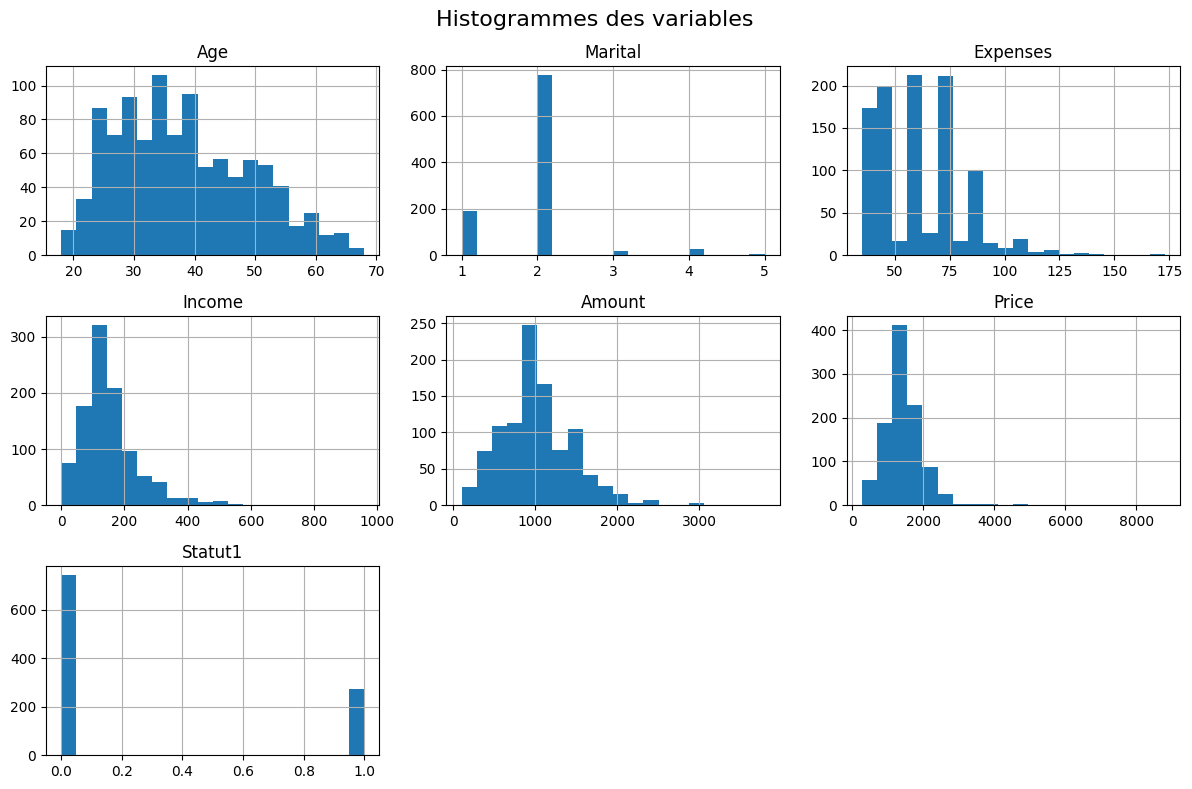

In [44]:
# Distribution des variables numériques
df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Histogrammes des variables", fontsize=16)
plt.tight_layout()
plt.show()

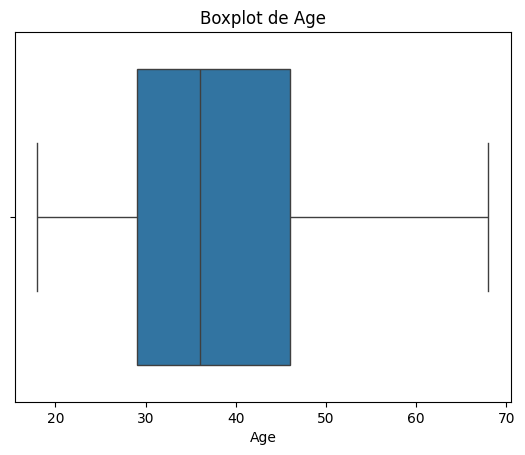

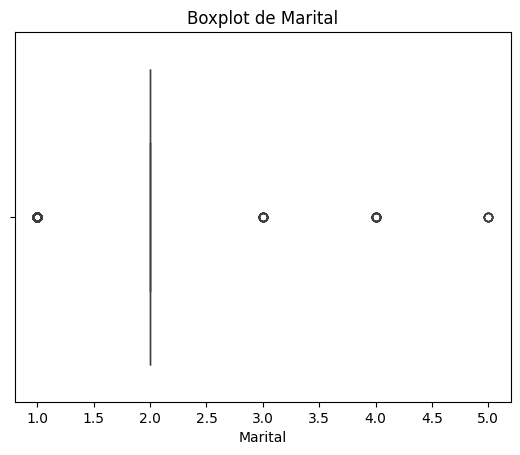

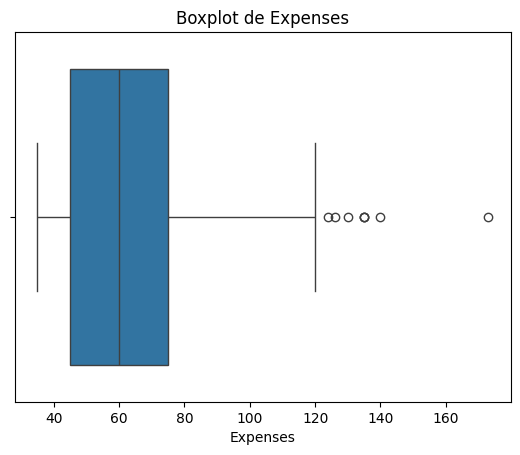

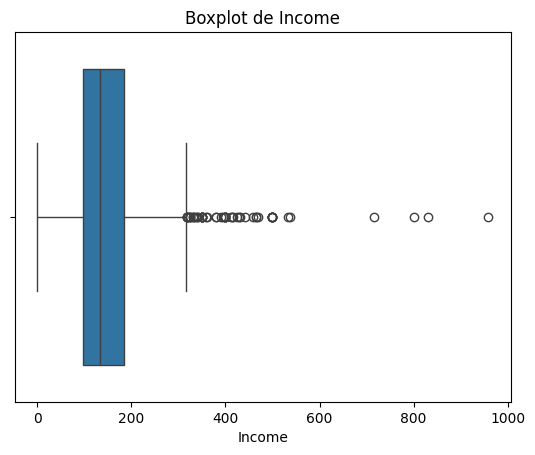

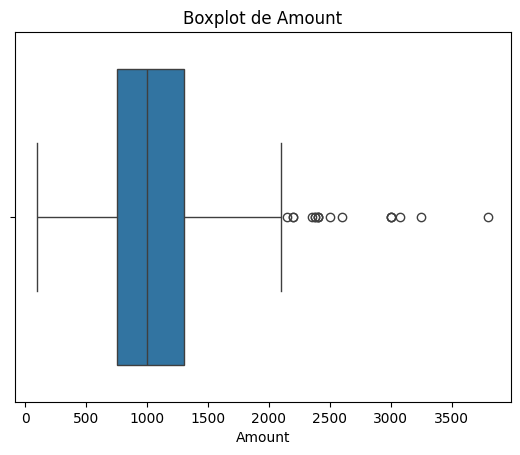

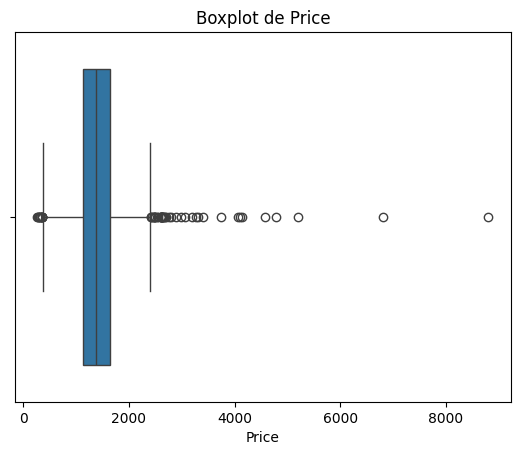

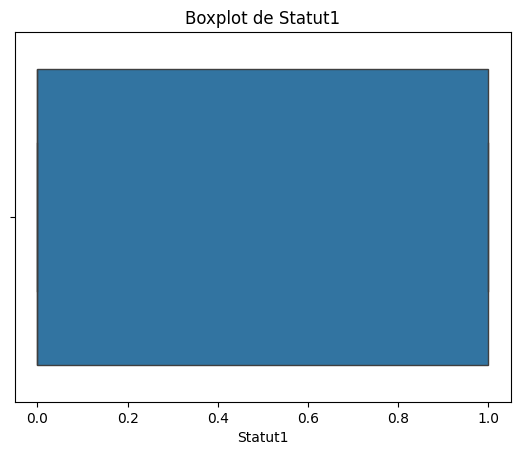

In [45]:
# Boxplots
for col in df.select_dtypes(include='number').columns:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

*  les variables Amounte ,Expenses,Price et Income
présentent des outliers .
- Les outliers peuvent introduire un biais dans les analyses et les prédictions, en particulier pour les modèles sensibles aux valeurs extrêmes (comme la régression).
- Une gestion efficace des outliers est nécessaire pour améliorer la robustesse des modèles.

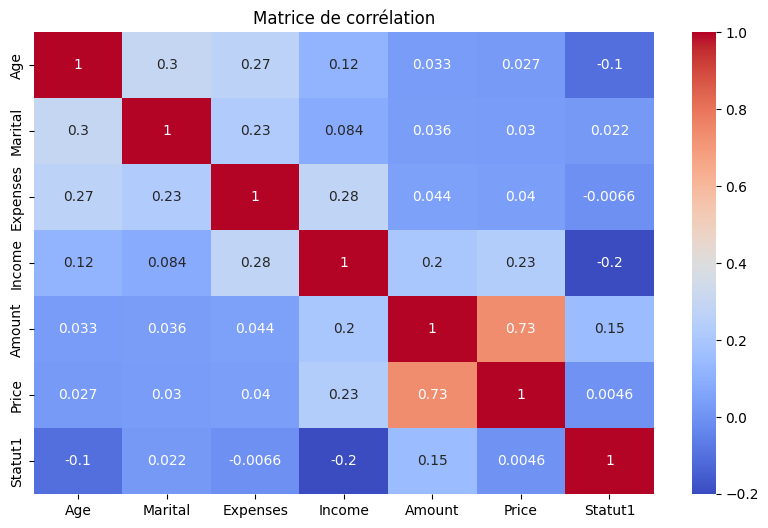

In [46]:
# Corrélation
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

- La forte corrélation entre `Amount` et `Price` peut poser des problèmes de multicolinéarité, en particulier pour les modèles linéaires.
- La multicolinéarité peut rendre les coefficients instables et nuire à l'interprétation des modèles.

In [47]:
df['Amount'].describe()

,Amount
count,1015.000000
mean,1034.745813
std,452.833277
min,100.000000
25%,750.000000
50%,1000.000000
75%,1300.000000
max,3800.000000


In [13]:
df['Statut1'].describe()
nsolva = df[df.Statut1 == 1]
solva = df[df.Statut1 == 0]

In [14]:
nsolva.Amount.describe()

,Amount
count,273.000000
mean,1144.084249
std,500.549188
min,170.000000
25%,850.000000
50%,1100.000000
75%,1400.000000
max,3250.000000


In [15]:
solva.Amount.describe()

,Amount
count,742.000000
mean,994.517520
std,427.330242
min,100.000000
25%,700.000000
50%,1000.000000
75%,1200.000000
max,3800.000000


 -  il y a un déséquilibre de classes dans la variable cible Statut1 :

- 742 cas pour Statut1 = 0
- 273 cas pour Statut1 = 1

---



- Suréchantillonnage de la classe minoritaire :

# ✅ la regression Logistique :

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Séparation X / y
X = df.drop(columns='Statut1')
y = df['Statut1']

# Découpage train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Équilibrage des classes avec SMOTE :

In [49]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve ,accuracy_score

# Modèle
log_model = LogisticRegression(class_weight='balanced', random_state=42)
log_model.fit(X_resampled, y_resampled)

# Prédictions
y_pred_log = log_model.predict(X_test_scaled)

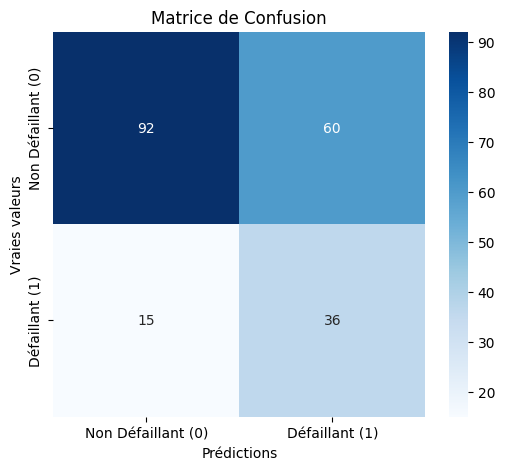

In [51]:
from sklearn.metrics import confusion_matrix
# 1. Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_log)

# 2. Affichage avec seaborn (graphique amélioré)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non Défaillant (0)", "Défaillant (1)"],
            yticklabels=["Non Défaillant (0)", "Défaillant (1)"])
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.show()

[[92 60]
 [15 36]]
              precision    recall  f1-score   support

         0.0       0.86      0.61      0.71       152
         1.0       0.38      0.71      0.49        51

    accuracy                           0.63       203
   macro avg       0.62      0.66      0.60       203
weighted avg       0.74      0.63      0.65       203

AUC : 0.7249742002063984


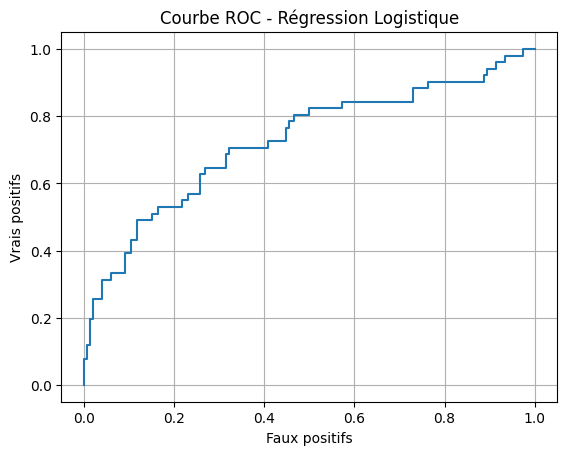

In [52]:
# Évaluation
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print("AUC :", roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:, 1]))

# ROC
fpr, tpr, _ = roc_curve(y_test, log_model.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel("Faux positifs")
plt.ylabel("Vrais positifs")
plt.title("Courbe ROC - Régression Logistique")
plt.grid()
plt.show()

In [53]:
print("Nombre total :", len(y_test))
print("Classe 0 dans test :", sum(y_test == 0))
print("Classe 1 dans test :", sum(y_test == 1))

Nombre total : 203
Classe 0 dans test : 152
Classe 1 dans test : 51


In [54]:
print("Nombre total :", len( y_resampled))
print("Classe 0 dans train :", sum(y_resampled == 0))
print("Classe 1 dans train :", sum(y_resampled == 1))

Nombre total : 1180
Classe 0 dans train : 590
Classe 1 dans train : 590


In [55]:
print("Nombre total :", len(y_train))
print("Classe 0 dans test :", sum(y_train == 0))
print("Classe 1 dans test :", sum(y_train == 1))

Nombre total : 812
Classe 0 dans test : 590
Classe 1 dans test : 222


#  # ✅ **la regression Logistique** sans ❌outliers(model final de regression logistique avec Recall=0,78 pour les cas NON solvables :

In [56]:
def detect_outliers_iqr(data, variable):
    Q1 = data[variable].quantile(0.25)
    Q3 = data[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((data[variable] < lower_bound) | (data[variable] > upper_bound))

# Exemple : détection des outliers pour Amount
df['outlier_amount'] = detect_outliers_iqr(df, 'Amount')

# Comptage des outliers par classe
df.groupby('Statut1')['outlier_amount'].sum()


,outlier_amount
Statut1,
0.0,8
1.0,9


In [57]:
# Liste des variables à tester
variables = ['Amount', 'Expenses', 'Price', 'Income']

# Boucle pour créer une colonne d'outliers pour chaque variable
for var in variables:
    df[f'outlier_{var.lower()}'] = detect_outliers_iqr(df, var)

# Regrouper par Statut1 et compter les outliers
outlier_counts = df.groupby('Statut1')[[f'outlier_{v.lower()}' for v in variables]].sum()

# Afficher les résultats
print(outlier_counts)


         outlier_amount  outlier_expenses  outlier_price  outlier_income
Statut1                                                                 
0.0                   8                 6             35              47
1.0                   9                 2             18               8


In [58]:
df_clean = df[
    ~(df['outlier_amount'] | df['outlier_expenses'] | df['outlier_price'] | df['outlier_income'])
]


In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Séparation X / y
Xc = df_clean.drop(columns='Statut1')
yc =df_clean['Statut1']

# Découpage train / test
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42)

# Standardisation
scaler = StandardScaler()
Xc_train_scaled = scaler.fit_transform(Xc_train)
Xc_test_scaled = scaler.transform(Xc_test)

In [61]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
Xc_resampled, yc_resampled = sm.fit_resample(Xc_train_scaled, yc_train)


# 👉verification des outliers :

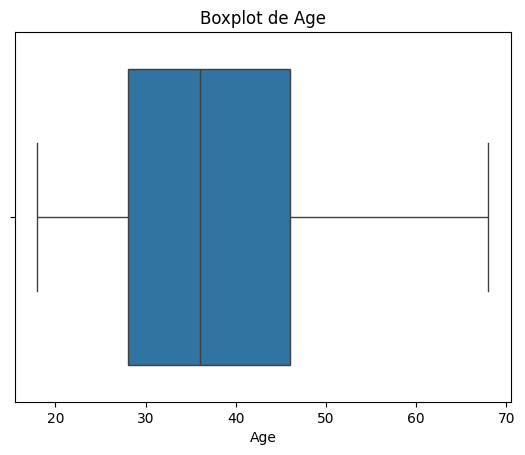

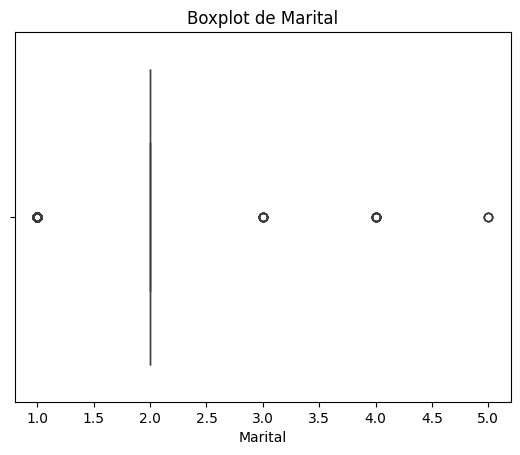

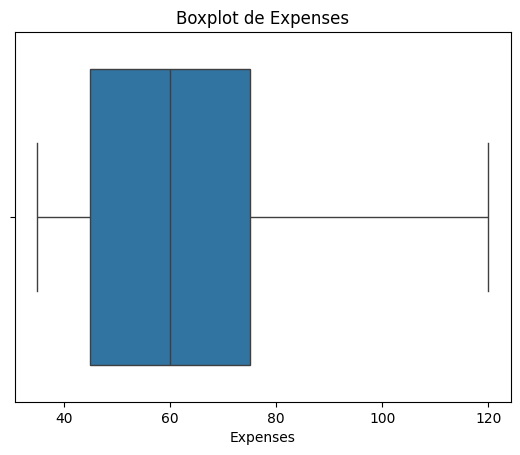

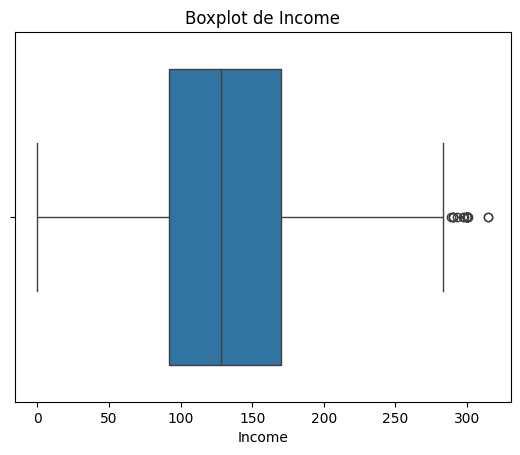

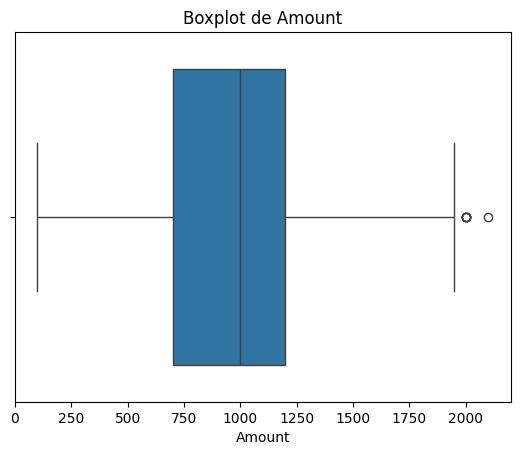

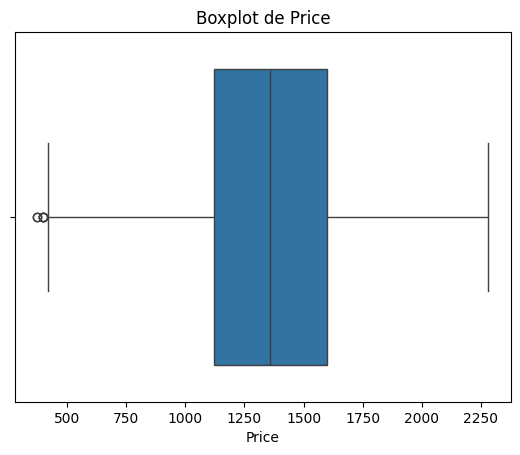

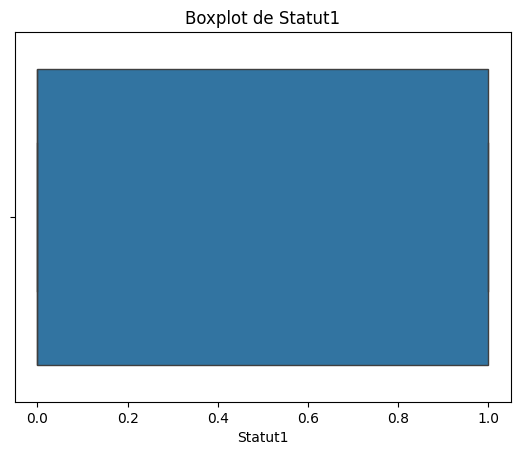

In [34]:
df_clean.describe()
# Boxplots
for col in df_clean.select_dtypes(include='number').columns:
    plt.figure()
    sns.boxplot(x=df_clean[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Modèle
log_modelc= LogisticRegression(class_weight='balanced', random_state=42)
log_modelc.fit(Xc_resampled, yc_resampled)

# Prédictions
yc_pred_log = log_modelc.predict(Xc_test_scaled)


📊 Rapport de classification :
               precision    recall  f1-score   support

         0.0       0.88      0.63      0.73       133
         1.0       0.43      0.76      0.55        49

    accuracy                           0.66       182
   macro avg       0.65      0.69      0.64       182
weighted avg       0.76      0.66      0.68       182



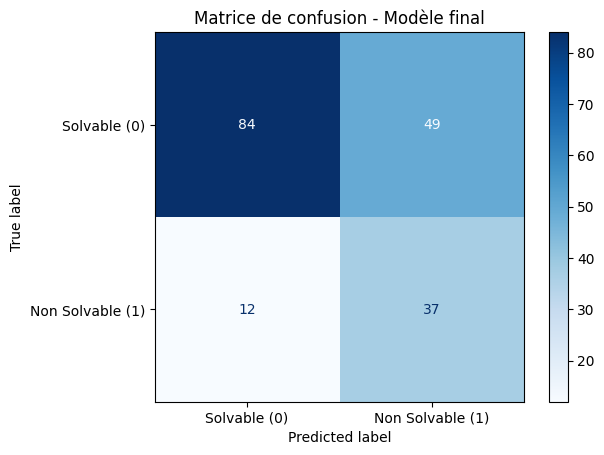

In [64]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt

# 4️⃣ Évaluation
print("📊 Rapport de classification :\n", classification_report(yc_test, yc_pred_log))
# Attention : pour roc_auc_score, on préfère les probabilités pour la classe 1print("📌 AUC ROC :", roc_auc_score(yc_test, y_pred_proba))

# 5️⃣ Matrice de confusion
cm = confusion_matrix(yc_test, yc_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Solvable (0)", "Non Solvable (1)"])
disp.plot(cmap='Blues')
plt.title("Matrice de confusion - Modèle final")
plt.grid(False)
plt.show()


#✅ utilisation de la validation croisée k-fold pour évaluer les performances des modèle de régression logistique :






In [81]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report,
                           accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, roc_curve, auc,
                           PrecisionRecallDisplay, precision_recall_curve)
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np

# 3. Pipeline avec standardisation
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=42, class_weight='balanced'))  # Ajout du poids équilibré
])

# 4. Grille d'hyperparamètres optimisée
param_grid = {
    'model__C': np.logspace(-3, 2, 6),  # [0.001, 0.01, ..., 100]
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear'],
    'model__max_iter': [500]
}

# 5. Recherche du meilleur modèle
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("Optimisation en cours...")
grid_search.fit(X_resampled, y_resampled)

# 6. Meilleur modèle
best_model = grid_search.best_estimator_
print("\n🔍 Meilleurs paramètres:", grid_search.best_params_)
print("🏆 Meilleur score F1 (validation):", grid_search.best_score_)





Optimisation en cours...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

🔍 Meilleurs paramètres: {'model__C': np.float64(0.1), 'model__max_iter': 500, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
🏆 Meilleur score F1 (validation): 0.6898078939584832


In [88]:

# 5. Optimisation du seuil de décision
y_proba = best_model.predict_proba(Xc_test_scaled)[:, 1]  # Probabilités classe positive
precisions, recalls, thresholds = precision_recall_curve(yc_test, y_proba)

# Calcul du F1-score pour chaque seuil
f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"\n🎯 Seuil optimal (max F1): {optimal_threshold:.4f}")


In [90]:
# 6. Évaluation avec seuil optimisé
y_pred_optimized = (y_proba >= optimal_threshold).astype(int)

print("\n📊 Rapport de classification optimisé:")
print(classification_report(yc_test, y_pred_optimized,
                          target_names=['Solvable', 'Non solvable']))

# 7. Visualisation
plt.figure(figsize=(15, 5))


📊 Rapport de classification optimisé:
              precision    recall  f1-score   support

    Solvable       0.85      0.78      0.82       133
Non solvable       0.52      0.63      0.57        49

    accuracy                           0.74       182
   macro avg       0.68      0.71      0.69       182
weighted avg       0.76      0.74      0.75       182



<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

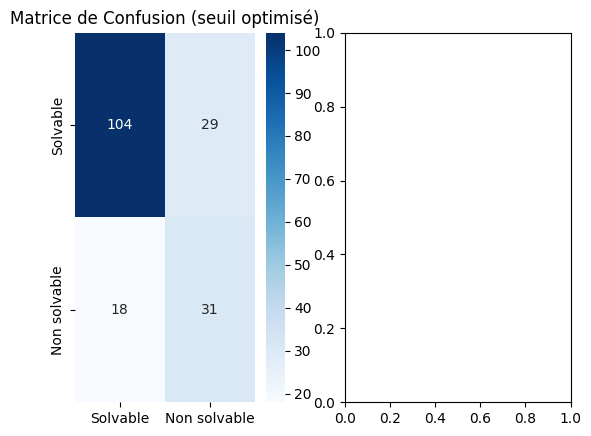

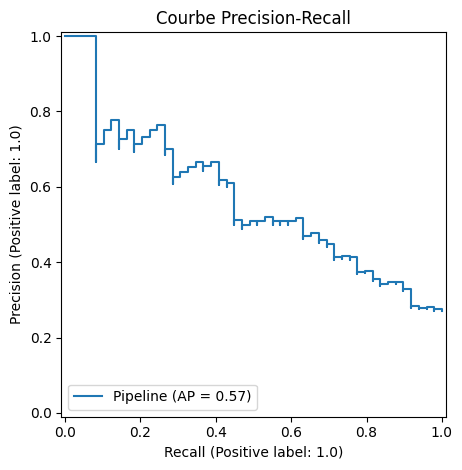

In [94]:
# Matrice de confusion
plt.subplot(1, 2, 1)
cm = confusion_matrix(yc_test, y_pred_optimized)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Solvable', 'Non solvable'],
            yticklabels=['Solvable', 'Non solvable'])
plt.title('Matrice de Confusion (seuil optimisé)')

# Courbe Precision-Recall
plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_estimator(best_model, Xc_test_scaled, yc_test)
plt.title('Courbe Precision-Recall')
plt.tight_layout()
plt.show()

In [100]:
# Correction du bloc de sauvegarde du modèle
model_data = {
    'model': best_model,
    'threshold': optimal_threshold,
    'features': list(range(X_resampled.shape[1])) if not hasattr(X_resampled, 'columns') else X_resampled.columns.tolist()
}
joblib.dump(model_data, 'mon_model||REG-LOG.pkl')
print("\n💾 Modèle sauvegardé sous 'mon_model||REG-LOG.pkl'")



💾 Modèle sauvegardé sous 'mon_model||REG-LOG.pkl'


In [101]:


# 9. Fonction de prédiction optimisée
def predict_with_optimal(model, threshold, X_new, feature_names=None):
    """
    Prédiction avec seuil personnalisé
    Args:
        model: Modèle entraîné
        threshold: Seuil optimal
        X_new: Données à prédire
        feature_names: Liste des noms de features attendus
    """
    if feature_names is not None:
        X_new = X_new[feature_names]  # Sélection des bonnes colonnes
    proba = model.predict_proba(X_new)[:, 1]
    return (proba >= threshold).astype(int)

# Exemple d'utilisation:
# predictions = predict_with_optimal(best_model, optimal_threshold, new_data,
#                                  feature_names=X_resampled.columns)

# KNN::

Modèle KNN entraîné avec 7 voisins

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.78      0.90      0.84       152
         1.0       0.46      0.25      0.33        51

    accuracy                           0.74       203
   macro avg       0.62      0.58      0.58       203
weighted avg       0.70      0.74      0.71       203


Matrice de confusion :


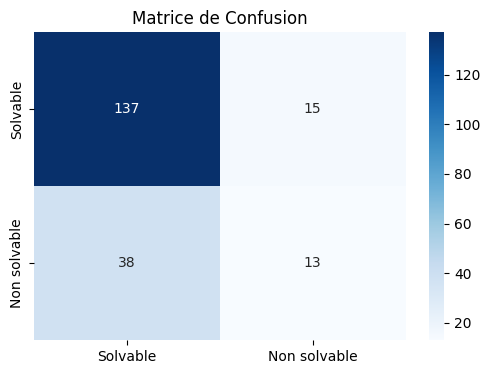

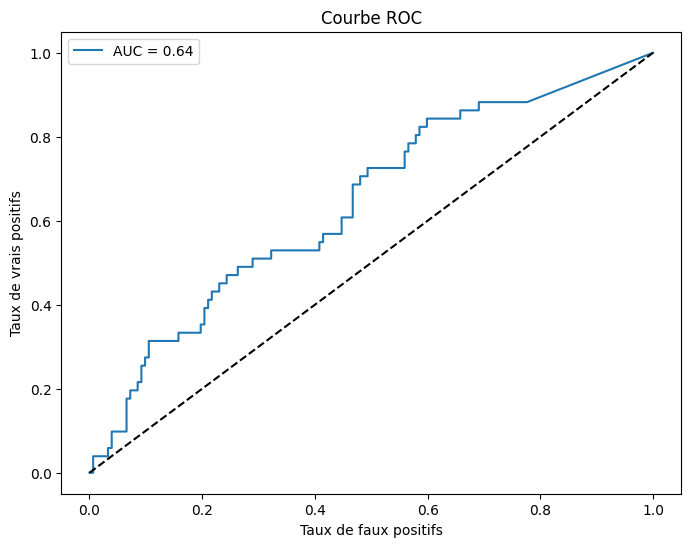

In [106]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

class ModeleKNN:
    def __init__(self, k=5, weights='uniform'):
        """Initialise le modèle KNN

        Args:
            k (int): Nombre de voisins (défaut: 5)
            weights (str): 'uniform' ou 'distance' (défaut: 'uniform')
        """
        self.model = KNeighborsClassifier(n_neighbors=k, weights=weights)

    def entrainer(self, X_train, y_train):
        """Entraîne le modèle sur les données fournies"""
        self.model.fit(X_train, y_train)
        print(f"Modèle KNN entraîné avec {self.model.n_neighbors} voisins")

    def evaluer(self, X_test, y_test):
        """Évalue le modèle et affiche les métriques"""
        # Prédictions
        y_pred = self.model.predict(X_test)
        y_proba = self.model.predict_proba(X_test)[:, 1]

        # Métriques
        print("\n" + "="*50)
        print("Rapport de classification :")
        print(classification_report(y_test, y_pred))

        print("\nMatrice de confusion :")
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix(y_test, y_pred),
                    annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Solvable', 'Non solvable'],
                    yticklabels=['Solvable', 'Non solvable'])
        plt.title('Matrice de Confusion')
        plt.show()

        # Courbe ROC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('Taux de faux positifs')
        plt.ylabel('Taux de vrais positifs')
        plt.title('Courbe ROC')
        plt.legend()
        plt.show()

        print("\n" + "="*50)

# Exemple d'utilisation avec vos données prétraitées :
if __name__ == "__main__":
    # Supposons que vous avez déjà :
    # X_train, X_test, y_train, y_test = ... (données prétraitées)

    # 1. Initialisation
    knn = ModeleKNN(k=7, weights='distance')  # Testez avec différents k

    # 2. Entraînement
    knn.entrainer(X_train,y_train)

    # 3. Évaluation
    knn.evaluer(X_test, y_test)

##✅  Evaluation de KNN avec K-fold Cross Validation :
#choix du meilleur model :

Seuil optimal trouvé : 1.00

Rapport de classification optimisé:
              precision    recall  f1-score   support

    Solvable       0.96      0.97      0.97       179
Non solvable       0.74      0.67      0.70        21

    accuracy                           0.94       200
   macro avg       0.85      0.82      0.83       200
weighted avg       0.94      0.94      0.94       200



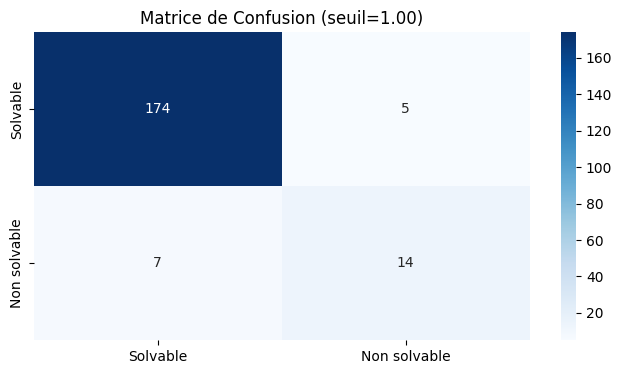

In [132]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from imblearn.pipeline import Pipeline  # Notez l'utilisation de imblearn.pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class ModeleKNNOptimise:
    def __init__(self):
        """Initialisation avec pipeline complet"""
        self.pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('knn', KNeighborsClassifier(weights='distance'))
        ])
        self.best_threshold = None

    def entrainer(self, X_train, y_train):
        """Entraînement avec optimisation du seuil"""
        self.pipeline.fit(X_train, y_train)

        # Optimisation du seuil de décision
        y_proba = self.pipeline.predict_proba(X_train)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y_train, y_proba)
        f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-8)
        self.best_threshold = thresholds[np.argmax(f1_scores)]

        print(f"Seuil optimal trouvé : {self.best_threshold:.2f}")

    def evaluer(self, X_test, y_test):
        """Évaluation avec seuil personnalisé"""
        y_proba = self.pipeline.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= self.best_threshold).astype(int)

        print("\nRapport de classification optimisé:")
        print(classification_report(y_test, y_pred,
                                 target_names=['Solvable', 'Non solvable']))

        # Visualisation
        plt.figure(figsize=(8, 4))
        sns.heatmap(confusion_matrix(y_test, y_pred),
                    annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Solvable', 'Non solvable'],
                    yticklabels=['Solvable', 'Non solvable'])
        plt.title(f"Matrice de Confusion (seuil={self.best_threshold:.2f})")
        plt.show()

# -------------------------------------------------------------------
# UTILISATION CORRECTE (partie importante)
# -------------------------------------------------------------------
if __name__ == "__main__":
    # 1. Initialisation
    knn_model = ModeleKNNOptimise()  # Crée une instance sans 'self'

    # 2. Entraînement (données doivent être définies)
    # Remplacez par vos vraies données:
    # knn_model.entrainer(X_train, y_train)

    # Exemple avec des données fictives (à adapter):
    from sklearn.datasets import make_classification
    X, y = make_classification(n_samples=1000, weights=[0.9, 0.1], random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    knn_model.entrainer(X_train, y_train)  # Sans 'self'

    # 3. Évaluation
    knn_model.evaluer(X_test, y_test)

In [137]:
joblib.dump(knn_model, 'mon_model||KNN.pkl')
print("\n💾 Modèle sauvegardé sous 'mon_model||KNN-LOG.pkl'")


💾 Modèle sauvegardé sous 'mon_model||KNN-LOG.pkl'
